In [ ]:
# MobileNetV3 -> SSD -> GRU

In [1]:
import tensorflow as tf
from tensorflow import keras 
# from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

2023-12-04 09:36:24.432922: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 09:36:24.473235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 09:36:25.272055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [3]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
target_images = target_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [4]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

print(origin_images.shape)
print(target_images.shape)

255 0
255 0
1.0 0.0
1.0 0.0
(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [5]:
def normalize_coordinates(coords, width=32, height=24):
    # Check the shape of the input coordinates
    if coords.shape[-1] != 8:
        raise ValueError("The last dimension of the input coordinates should be 8.")

    # Create a normalization array
    normalization_factors = np.array([width, height, width, height, width, height, width, height])

    # Normalize the coordinates
    normalized_coords = coords / normalization_factors

    return normalized_coords

In [6]:
norm_location = normalize_coordinates(coordinates)
print(norm_location.shape)

from keras.utils import to_categorical

number_labels = to_categorical(numbers_labels, num_classes=5)
print(number_labels.shape)

(13276, 4, 8)
(13276, 5)


In [7]:
transformed_data_list = []

for i in range(norm_location.shape[0]):
    xmin = norm_location[i, :, 0::2].min(axis=1)
    ymin = norm_location[i, :, 1::2].min(axis=1)
    xmax = norm_location[i, :, 0::2].max(axis=1)
    ymax = norm_location[i, :, 1::2].max(axis=1)
    bounding_box = np.array([xmin, ymin, xmax, ymax]).T.reshape(1, -1)
    transformed_data_list.append(bounding_box)

norm_location = np.array(transformed_data_list)

In [8]:
print(norm_location[9000])

[[0.25       0.625      0.46875    1.         0.         0.
  0.25       0.33333333 0.46875    0.54166667 0.71875    0.95833333
  0.8125     0.66666667 1.         1.        ]]


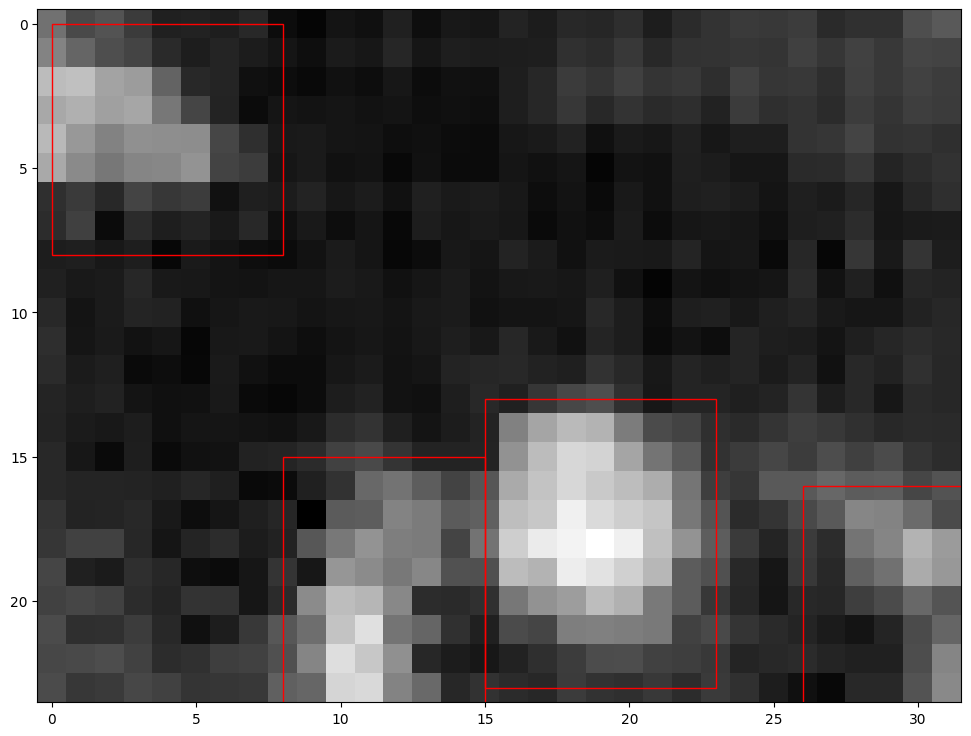

In [9]:
import matplotlib.patches as patches

def draw_boxes_on_normalized_coords(image, normalized_coords, width=32, height=24):
    """
    정규화된 좌표를 사용하여 이미지 위에 바운딩 박스를 그리는 함수.
    image: 대상 이미지.
    normalized_coords: 정규화된 좌표.
    width: 이미지의 너비.
    height: 이미지의 높이.
    """
    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalization_factors = np.tile([width, height], 8)  # 형태를 (16,)으로 조정
    denormalized_coords = normalized_coords * denormalization_factors

    # 이미지가 4차원 배열인 경우 첫 번째 이미지만 사용
    if image.ndim == 4:
        image = image[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image, cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for i in range(0, len(denormalized_coords), 4):
        xmin, ymin, xmax, ymax = denormalized_coords[i:i+4]

        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()


draw_boxes_on_normalized_coords(origin_images[9000:9001], norm_location[9000:9001])

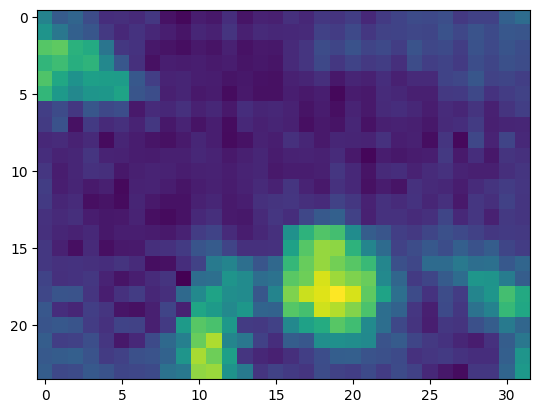

4


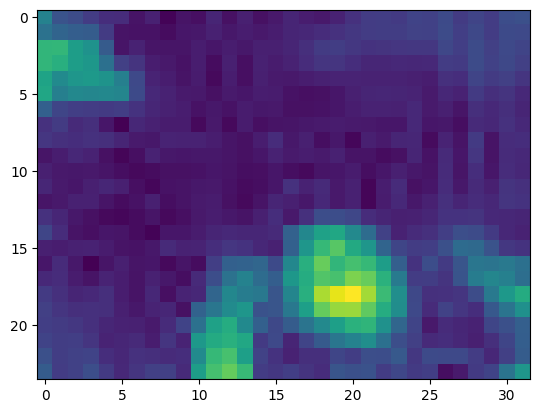

4


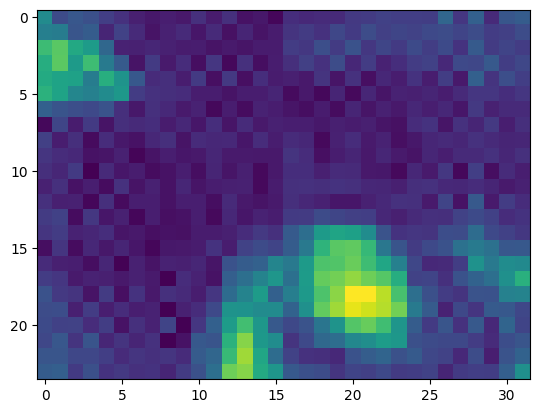

4


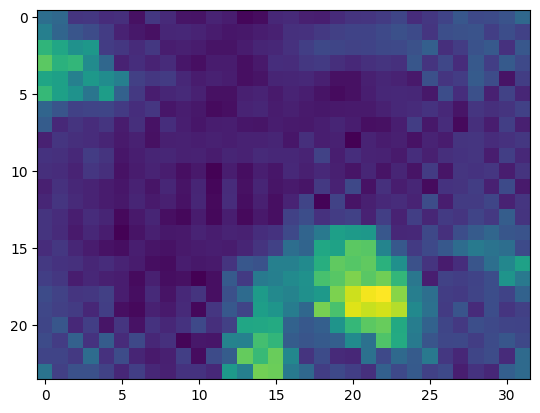

4


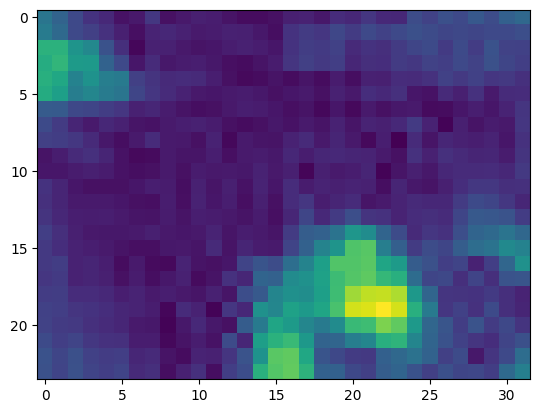

4


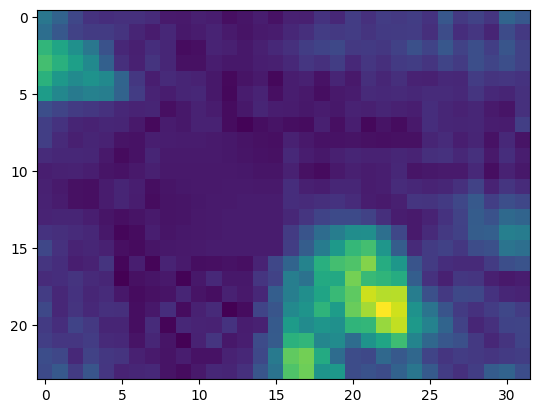

4


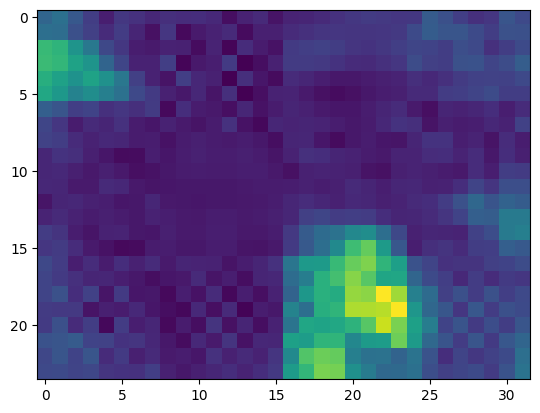

4


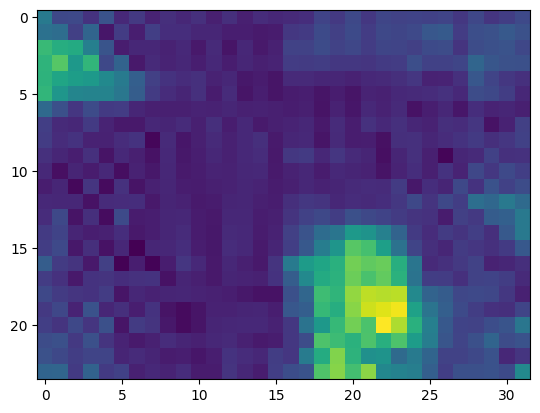

3


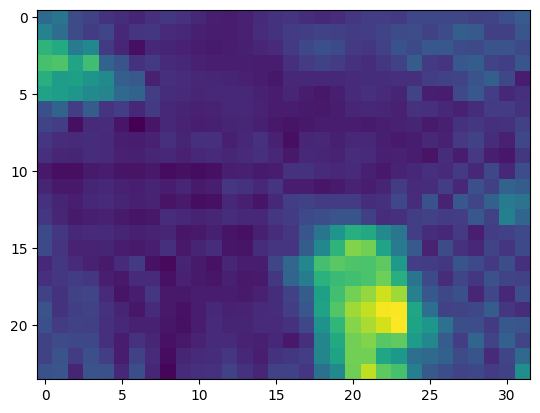

3


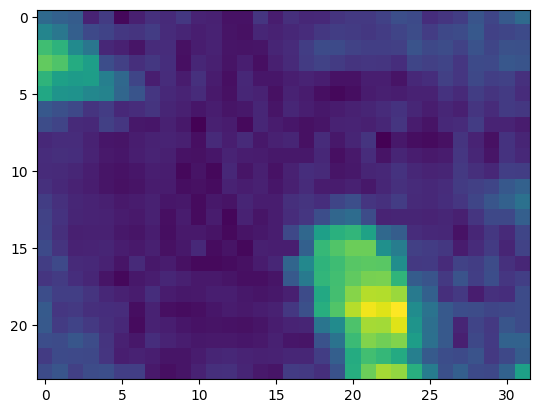

3


In [10]:
for i in range(9000, 9010):
    plt.imshow(origin_images[i])
    plt.show()
    print(numbers_labels[i])


In [11]:
print(number_labels[9000:9010])

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [12]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
from keras.layers import GRU, Concatenate, MaxPooling2D
from keras.models import Model
from keras.layers import Multiply
from keras.layers import MultiHeadAttention

# strategy = tf.distribute.MirroredStrategy()

# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, concatenate


def inception_module(x,
                    #  filters_3x3_reduce,
                     filters_5x5_reduce,
                     filters_pool_proj):
    # path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    # return concatenate([path2, path3, path4], axis=3)
    return concatenate([path3, path4], axis=3)


def STMModel():
    # 이미지 입력
    # input_layer = Input(shape=(None, None, 1))
    inputs_image = Input(shape=(24, 32, 1))
    # resized_input = Lambda(resize_images)(input_layer)

    inception = inception_module(inputs_image,
                                # filters_1x1=64,
                                # filters_3x3=128,
                                filters_5x5_reduce=16,
                                # filters_5x5=32,
                                filters_pool_proj=32)
    
    x1 = keras.layers.GlobalAveragePooling2D()(inception)
    # x1 = keras.layers.MaxPool2D()(inception)
    latent_vector = Flatten()(x1)

    # latent = Dense(32, activation='relu', dtype = 'float32')(latent_vector) 

    number_output = Dense(5, activation='softmax', name='number_output', dtype = 'float32')(latent)
    
    # model2 = Model(inputs_image, [number_output, reconstructed_image])
    model2 = Model(inputs_image, number_output)
    model2.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    return model2


model2 = STMModel()
model2.summary()


2023-12-04 09:36:48.057600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2023-12-04 09:36:48.059323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2023-12-04 09:36:48.060856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2023-12-04 09:36:48.062440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 32, 1)            0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 24, 32, 16)           32        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 32, 32)           64        ['max_pooling2d[0][0]']   

In [22]:
# import tensorflow as tf
# from tensorflow import keras 
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings 
# from IPython.display import Image

# warnings.filterwarnings('ignore')
# from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
# from keras.layers import BatchNormalization, Dropout, Activation, concatenate
# from keras.models import Model
# from keras.layers import GRU, Concatenate, MaxPooling2D
# from keras.models import Model
# from keras.layers import Multiply
# from keras.layers import MultiHeadAttention

# # strategy = tf.distribute.MirroredStrategy()

# # print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, concatenate

# def inception_module(x,
#                     filters_3x3_reduce,
#                     filters_5x5_reduce,
#                     filters_pool_proj):
#     path2 = Conv2D(filters_3x3_reduce, (3, 3), padding='same', activation='relu', dtype = 'float32')(x)

#     path3 = Conv2D(filters_5x5_reduce, (5, 5), padding='same', activation='relu', dtype = 'float32')(x)

#     path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
#     path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', dtype = 'float32')(path4)
#     return concatenate([path2, path3, path4], axis=3)



# def STMModel():
#     # 이미지 입력
#     # input_layer = Input(shape=(None, None, 1))
#     inputs_image = Input(shape=(24, 32, 1))
#     # resized_input = Lambda(resize_images)(input_layer)

#     inception = inception_module(inputs_image,
#                                 # filters_1x1=64,
#                                 filters_3x3_reduce=96,
#                                 # filters_3x3=128,
#                                 filters_5x5_reduce=16,
#                                 # filters_5x5=32,
#                                 filters_pool_proj=32)
    
#     x1 = keras.layers.GlobalAveragePooling2D()(inception)
#     latent_vector = Flatten()(x1)

#     latent = Dense(32, activation='relu', dtype = 'float32')(latent_vector)

#     number_output = Dense(5, activation='softmax', name='number_output', dtype = 'float32')(latent)
    
#     # model2 = Model(inputs_image, [number_output, reconstructed_image])
#     model2 = Model(inputs_image, number_output)
#     model2.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
#     return model2


In [ ]:
# model2 = STMModel()
# model2.summary()

In [19]:
# model2.compile(optimizer='adam', loss=['categorical_crossentropy', 'mse'],  metrics=['accuracy'])

In [ ]:
# import os
# from keras.utils import plot_model

# # 모델을 생성
# model2 = DetectionModel()

# # 모델을 이미지로 그리고 저장
# plot_model(model2, to_file='./detection_model.png', show_shapes=True, show_layer_names=True)

# # 이미지를 표시
# # Image(filename='./detection_model.png')


In [ ]:
# import tensorflow as tf

# def smooth_l1_loss(y_true, y_pred, delta=1.0):
#     abs_diff = tf.abs(y_true - y_pred)
#     loss = tf.where(tf.less(abs_diff, delta), 0.5 * tf.square(abs_diff), delta * (abs_diff - 0.5 * delta))
#     return tf.reduce_mean(loss)

In [ ]:
# import tensorflow as tf

# def iou(y_true, y_pred):
#     """
#     TensorFlow를 사용하여 IoU를 계산하는 함수.
#     y_true: 실제 바운딩 박스 좌표, 형태는 [batch, num_boxes, 4] (여기서 4는 xmin, ymin, xmax, ymax)
#     y_pred: 예측된 바운딩 박스 좌표, 형태는 [batch, num_boxes, 4]
#     """
#     # 좌표를 분리
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)
#     true_xmin, true_ymin, true_xmax, true_ymax = tf.split(y_true, 4, axis=-1)
#     pred_xmin, pred_ymin, pred_xmax, pred_ymax = tf.split(y_pred, 4, axis=-1)

#     # 교차 영역의 좌표 계산
#     intersect_xmin = tf.maximum(true_xmin, pred_xmin)
#     intersect_ymin = tf.maximum(true_ymin, pred_ymin)
#     intersect_xmax = tf.minimum(true_xmax, pred_xmax)
#     intersect_ymax = tf.minimum(true_ymax, pred_ymax)

#     # 교차 영역의 넓이와 높이
#     intersect_width = tf.maximum(0., intersect_xmax - intersect_xmin)
#     intersect_height = tf.maximum(0., intersect_ymax - intersect_ymin)

#     # 교차 영역의 면적
#     intersect_area = intersect_width * intersect_height

#     # 각 바운딩 박스의 면적
#     true_area = (true_xmax - true_xmin) * (true_ymax - true_ymin)
#     pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)

#     # 합집합 영역의 면적
#     union_area = true_area + pred_area - intersect_area

#     # IoU 계산
#     iou = intersect_area / tf.maximum(union_area, tf.keras.backend.epsilon())

#     return iou

In [ ]:
# from tensorflow.keras.metrics import Precision, Recall

# learning_rate = 0.0001
# N_TRAIN = 13276
# N_BATCH = 32
# N_EPOCHS = 100

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
#                                                           decay_steps = N_TRAIN / N_BATCH * 10,
#                                                           decay_rate = 0.5,
#                                                           staircase = True)

# model.compile(
#     keras.optimizers.Adam(lr_schedule), 
#     loss = 'categorical_crossentropy',
#     metrics=['accuracy', Precision(), Recall()])

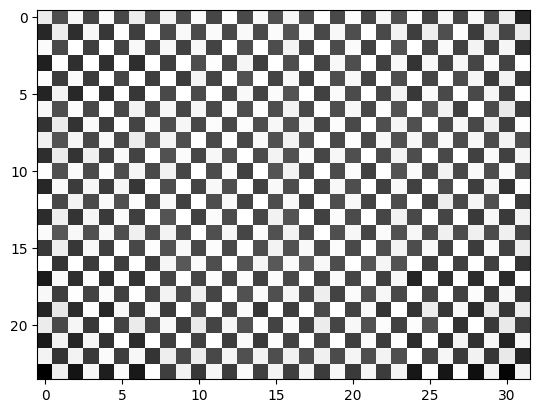

[1. 0. 0. 0. 0.]


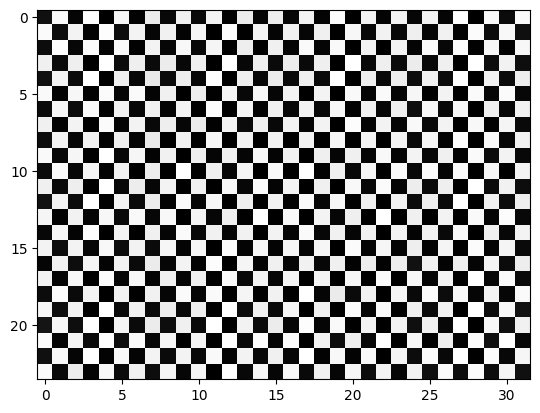

[1. 0. 0. 0. 0.]


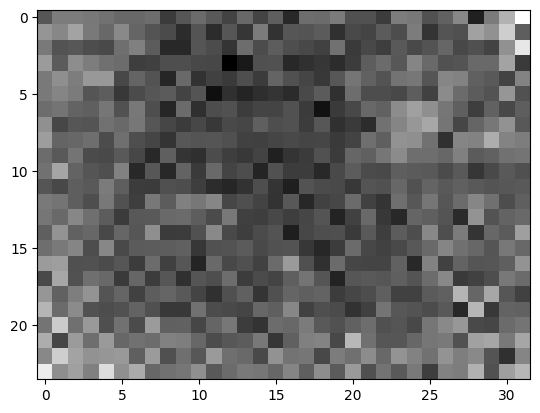

[1. 0. 0. 0. 0.]


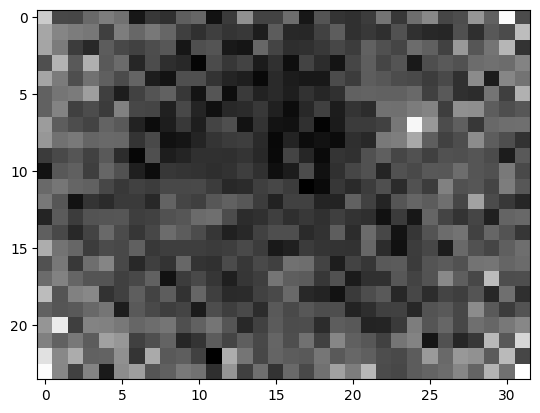

[1. 0. 0. 0. 0.]


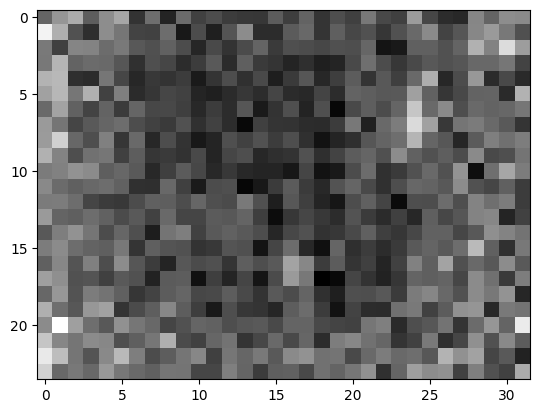

[1. 0. 0. 0. 0.]


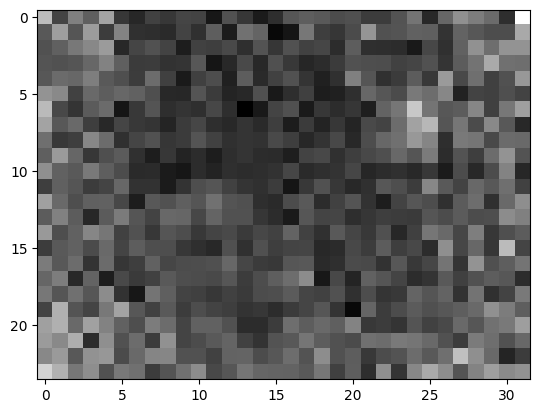

[1. 0. 0. 0. 0.]


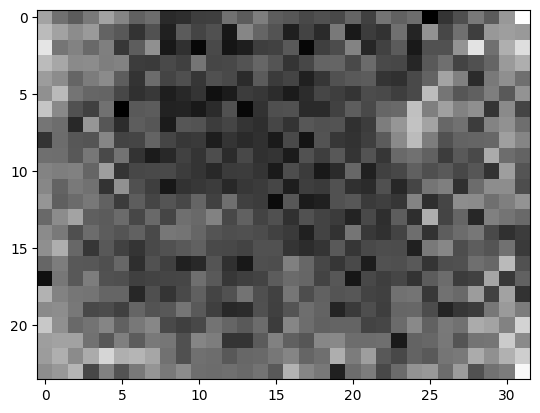

[1. 0. 0. 0. 0.]


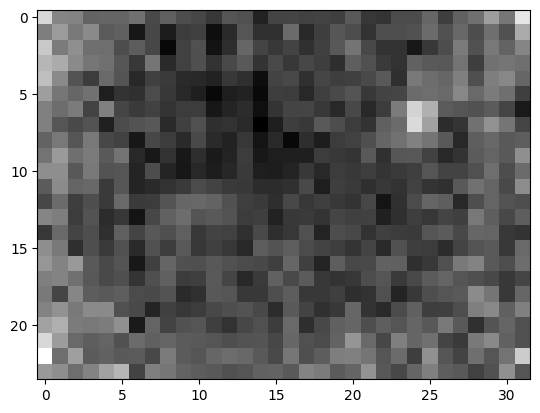

[1. 0. 0. 0. 0.]


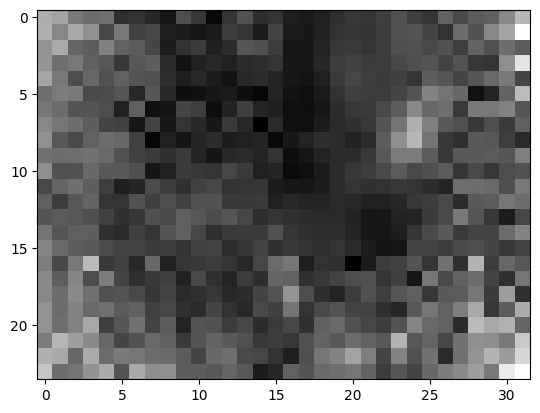

[1. 0. 0. 0. 0.]


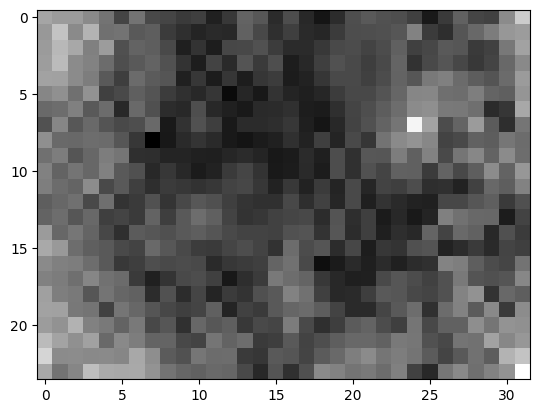

[1. 0. 0. 0. 0.]


In [13]:
# 13276 - 1327
# origin_images
# number_labels


# train_dataset = origin_images[:11949]
# train_number_labels = number_labels[:11949]
# train_target_image = target_images[:11949]
# test_dataset = origin_images[11949:]
# test_number_labels = number_labels[11949:]
# test_target_image = target_images[11949:]

for i in range(10):
    plt.imshow(origin_images[i], cmap='gray')
    plt.show()
    print(number_labels[i])

In [14]:
origin_images[0].max()

1.0

In [15]:
N_BATCH = 32
hist = model2.fit(
    origin_images, number_labels,
    epochs=100,
    batch_size= N_BATCH,
    verbose=1,  # 사용자 정의 콜백 추가
)

Epoch 1/100


2023-12-04 09:37:38.527091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-12-04 09:37:39.239853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-04 09:37:39.243852: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f64140376e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-04 09:37:39.243894: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-04 09:37:39.243907: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-04 09:37:39.243917: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-04 09:37:39.243928: I tensorflow/

415/415 [==============================] - 6s 6ms/step - loss: 1.2885 - accuracy: 0.5384
Epoch 2/100
415/415 [==============================] - 2s 6ms/step - loss: 1.2363 - accuracy: 0.5405
Epoch 3/100
415/415 [==============================] - 2s 6ms/step - loss: 1.1821 - accuracy: 0.5405
Epoch 4/100
415/415 [==============================] - 2s 6ms/step - loss: 1.0832 - accuracy: 0.5620
Epoch 5/100
415/415 [==============================] - 2s 6ms/step - loss: 0.9960 - accuracy: 0.6033
Epoch 6/100
415/415 [==============================] - 2s 6ms/step - loss: 0.9490 - accuracy: 0.6204
Epoch 7/100
415/415 [==============================] - 2s 6ms/step - loss: 0.9215 - accuracy: 0.6295
Epoch 8/100
415/415 [==============================] - 2s 6ms/step - loss: 0.9054 - accuracy: 0.6346
Epoch 9/100
415/415 [==============================] - 2s 6ms/step - loss: 0.8925 - accuracy: 0.6358
Epoch 10/100
415/415 [==============================] - 2s 6ms/step - loss: 0.8822 - accuracy: 0.6382
E

In [ ]:
# N_BATCH = 252
# hist = model.fit(
#     train_dataset, train_number_labels, 
#     validation_data = (test_dataset, test_number_labels),
#     epochs=100,
#     batch_size= N_BATCH,
#     verbose=1,  # 사용자 정의 콜백 추가
# )

In [ ]:
# plt.imshow(test_dataset[0])
# for i in range(20):
#     plt.imshow(test_dataset[i], cmap='gray')
#     plt.show()
#     res = model.predict(test_dataset[i].reshape(1, 24, 32, 1))
#     print(res[0].argmax())

In [ ]:
# # print(test_dataset[0].shape)
# # print(test_dataset[0].shape)
# # print(test_dataset[0].reshape(1, 24, 32, 1).shape)
# # plt.imshow(test_dataset[0])
# for i in range(20):
#     plt.imshow(test_dataset[i], cmap='gray')
#     plt.show()
#     res = model2.predict(test_dataset[i].reshape(1, 24, 32, 1))
#     print(res[0].argmax())


In [18]:
model2.save('./v1_12.h5')

In [17]:
print(origin_images.shape, number_labels.shape)

(13276, 24, 32, 1) (13276, 5)


In [19]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

# train_dataset, train_number_labels,

# 초기 모델 로드
model = tf.keras.models.load_model('./v1_12.h5')

# 프루닝 설정
epochs = 30
batch_size = 32
num_train_samples = origin_images.shape[0]
end_step = np.ceil(num_train_samples / batch_size).astype(np.int32) * epochs
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.80,
                                                 begin_step=0,
                                                 end_step=end_step)
}

# 모델에 프루닝 래퍼 적용
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)

# 프루닝 모델 컴파일 및 훈련
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy'])

callbacks = [
    UpdatePruningStep()
]

model_for_pruning.fit(origin_images, number_labels, epochs=epochs, callbacks=callbacks)

# 프루닝 제거 및 최종 모델 저장
final_model = sparsity.strip_pruning(model_for_pruning)
final_model.save('pruned_model.h5')


Epoch 1/50
415/415 [==============================] - 5s 7ms/step - loss: 0.6440 - accuracy: 0.7279
Epoch 2/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6432 - accuracy: 0.7319
Epoch 3/50
415/415 [==============================] - 3s 7ms/step - loss: 0.6420 - accuracy: 0.7296
Epoch 4/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6406 - accuracy: 0.7306
Epoch 5/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6442 - accuracy: 0.7309
Epoch 6/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6440 - accuracy: 0.7265
Epoch 7/50
415/415 [==============================] - 3s 7ms/step - loss: 0.6433 - accuracy: 0.7266
Epoch 8/50
415/415 [==============================] - 3s 7ms/step - loss: 0.6455 - accuracy: 0.7248
Epoch 9/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6413 - accuracy: 0.7305
Epoch 10/50
415/415 [==============================] - 3s 8ms/step - loss: 0.6393 - accuracy: 0.7298

In [20]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 32, 1)            0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 24, 32, 16)           32        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 32, 32)           64        ['max_pooling2d[1][0]']   

In [25]:
# train_dataset.dtype

dtype('uint8')

In [37]:
# print(train_dataset[0].max(), train_dataset[0].min())

255 17


In [38]:
# qt_dataset = train_dataset / train_dataset.max()

In [39]:
# print(qt_dataset.shape, qt_dataset.max(), qt_dataset.min())

(11949, 24, 32, 1) 1.0 0.0


In [21]:

train_dataset = origin_images[:11949]
train_number_labels = number_labels[:11949]
train_target_image = target_images[:11949]
test_dataset = origin_images[11949:]
test_number_labels = number_labels[11949:]
test_target_image = target_images[11949:]

In [22]:
batch_size = 32
train_dataset_tf = tf.data.Dataset.from_tensor_slices(test_dataset)
# train_dataset을 배치로 만듦
batched_train_dataset = train_dataset_tf.batch(batch_size)

In [23]:
import tensorflow as tf

# 기존 모델 로드
model = tf.keras.models.load_model('pruned_model.h5')

# 대표 데이터셋을 준비하는 함수
def representative_data_gen():
    for input_value in batched_train_dataset.take(100):
        yield [input_value]

# 훈련 데이터셋을 로드하고 배치 처리
# 여기서 test_dataset와 batch_size는 적절한 값으로 설정해야 합니다.
batched_train_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).batch(batch_size)
batched_train_dataset = batched_train_dataset.map(lambda x: tf.cast(x, tf.float32))

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 float32로 제한
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 입력과 출력을 float32로 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 모델을 TFLite 모델로 변환
tflite_quant_model = converter.convert()

# TFLite 모델 저장
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmpox3fzbh1/assets


INFO:tensorflow:Assets written to: /tmp/tmpox3fzbh1/assets
2023-12-04 09:48:27.803836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-04 09:48:27.803871: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-04 09:48:27.804196: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpox3fzbh1
2023-12-04 09:48:27.805012: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-12-04 09:48:27.805026: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpox3fzbh1
2023-12-04 09:48:27.809044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-12-04 09:48:27.809567: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-12-04 09:48:27.829650: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

In [27]:


# from PIL import Image
# import numpy as np

# # Load the uploaded image file
# image_path = 'test/2023-11-04 03-29-16/1041_png.png'
# image = Image.open(image_path)

# # It seems there was an issue with the conversion process that led to a uniform array of zeros.
# # Let's first check the original image and its array to see if the conversion was done correctly.
# image_gray = image.convert('L')

# image_resized = image_gray.resize((32, 24))

# # Convert the image to a numpy array again without normalization to check its content
# image_array_check = np.asarray(image_resized)

# # Display the unique values in the array to verify the content
# np.unique(image_array_check)

# # The array contains a variety of values, indicating the image is not uniform and the conversion to a flat array of zeros was incorrect.
# # Let's correct the conversion process.

# # Normalize the image array properly
# image_array_normalized = image_array_check / 255.0

# # Convert the normalized array to a 1D array suitable for C array initialization
# # We'll use integer values scaled to [0, 255] for the C array
# image_array_int = image_array_check.flatten()

# # Convert the image array to a list of hex values
# image_array_hex = ['0x{:02x}'.format(pixel) for pixel in image_array_int]

# # Format the C array
# c_array = ', '.join(image_array_hex)
# c_array_formatted = f'const uint8_t image_data[24*32] = {{{c_array}}};'

# # Based on the provided code snippet, let's save the image data to a binary file.
# # The image data is already flattened and normalized, we just need to save it.

# # Convert the normalized array to bytes
# binary_data = image_array_normalized.astype(np.uint8).tobytes()

# # Define the path for the binary file
# binary_file_path = './image_data.bin'

# # Write the binary data to the file
# with open(binary_file_path, 'wb') as bin_file:
#     bin_file.write(binary_data)

# binary_file_path  # Return the file path for the user to download the binary file


# print(c_array_formatted)  # Print the first 500 characters for brevity





const uint8_t image_data[24*32] = {0x55, 0x58, 0x53, 0x5a, 0x96, 0x98, 0x7e, 0x73, 0x24, 0x13, 0x0c, 0x28, 0x27, 0x29, 0x21, 0x2f, 0x21, 0x24, 0x11, 0x19, 0x19, 0x2c, 0x1a, 0x13, 0x25, 0x2b, 0x1d, 0x22, 0x2b, 0x3f, 0x25, 0x4f, 0x62, 0x56, 0x4f, 0x6d, 0x92, 0xad, 0x99, 0x84, 0x45, 0x28, 0x24, 0x28, 0x33, 0x21, 0x21, 0x1b, 0x35, 0x0f, 0x1b, 0x11, 0x1e, 0x16, 0x1d, 0x19, 0x27, 0x15, 0x15, 0x18, 0x2a, 0x2c, 0x2a, 0x24, 0x55, 0x69, 0x5b, 0x7c, 0xbf, 0xd4, 0xae, 0xa6, 0x4e, 0x3a, 0x23, 0x31, 0x23, 0x2a, 0x20, 0x1a, 0x0e, 0x18, 0x0d, 0x21, 0x20, 0x19, 0x0e, 0x18, 0x20, 0x22, 0x15, 0x2b, 0x20, 0x2b, 0x23, 0x13, 0x55, 0x4b, 0x5c, 0x77, 0xab, 0xbf, 0xb6, 0x91, 0x66, 0x41, 0x32, 0x1a, 0x20, 0x18, 0x24, 0x14, 0x18, 0x05, 0x22, 0x06, 0x24, 0x15, 0x20, 0x14, 0x15, 0x14, 0x22, 0x12, 0x3e, 0x29, 0x41, 0x3e, 0x48, 0x4a, 0x47, 0x53, 0x94, 0xa6, 0x96, 0x88, 0x60, 0x55, 0x28, 0x31, 0x11, 0x31, 0x25, 0x29, 0x25, 0x27, 0x0a, 0x35, 0x14, 0x1c, 0x13, 0x20, 0x1e, 0x22, 0x0d, 0x1a, 0x1d, 0x1c, 0x1b, 0x15, 0x48,

In [ ]:
import os
import re
import cv2
import numpy as np

def extract_number(filename):
    match = re.search(r'(\d+)_png', filename)
    if match:
        return int(match.group(1))
    return None

def make_video_from_images(image_folder, video_name, fps=10.0):
    # 이미지 폴더 내의 모든 파일들을 가져옵니다.
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

    # 숫자 기준으로 이미지들을 정렬합니다.
    images.sort(key=extract_number)

    # 첫 번째 이미지를 통해 프레임의 너비와 높이를 가져옵니다.
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    h, w, layers = frame.shape
    size = (w, h)

    # VideoWriter 객체를 초기화합니다.
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    # 이미지들을 하나씩 동영상에 추가합니다.
    for image in images:
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        out.write(img)

    # 작업 완료 후, VideoWriter 객체를 해제합니다.
    out.release()

def save_draw_boxes_on_image(image, normalized_coords, save_path, num_people=None, width=32, height=24):
    normalized_coords = normalized_coords.squeeze()
    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]
    if image.ndim == 4:
        image = image[0]
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')
    if num_people is not None:
        ax.text(0.5, 0.1, f"Number of people: {num_people}", 
                transform=ax.transAxes, 
                color='white', 
                ha="center", 
                va="center", 
                fontsize=12, 
                bbox=dict(boxstyle="round", fc="red"))
    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the axis
        ax.add_patch(rect)
    plt.savefig(save_path)
    plt.close()  # 이 라인을 추가하여 화면에 표시되는 창을 닫습니다.
    return save_path

def generate_video_from_images():
    # 예측할 이미지 경로(예측 후 동영상으로 변환될 이미지)
    image_dir = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/original/Video/2023-11-04 03-32-16/'
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=extract_number)
    print(image_files)
    frame_height, frame_width = 24, 32
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        img = img.reshape(24, 32, 1)
        img_batch = np.expand_dims(img, axis=0)
        res = model.predict(img_batch / img_batch.max())
        # 예측 한 이미지를 저장할 폴더
        output_folder = "/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/img2/"
        save_path = os.path.join(output_folder, image_file)

        saved_image_path = save_draw_boxes_on_image(img, res[2][:], save_path, res[1].argmax())
        saved_image_gray = cv2.imread(saved_image_path, cv2.IMREAD_GRAYSCALE)
        
        saved_image = cv2.cvtColor(saved_image_gray, cv2.COLOR_GRAY2BGR)

    # 이 부분에서 이미지들을 동영상으로 만드는 함수를 호출합니다.
    # 예측 한 이미지를 저장할 폴더와 같은 폴더
    image_folder = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/img2/'  # 이미지 폴더 경로
    video_name = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/video4.avi'  # 저장될 동영상 파일 이름
    make_video_from_images(image_folder, video_name)
    print("Video generated successfully.")

if __name__ == "__main__":
    generate_video_from_images()
